In [1]:
import pandas as pd

In [17]:
flags = pd.read_csv('flags.csv', delimiter=';')[["name", "image"]]

In [21]:
flags.dropna(subset=['image'])


,name,image
0,Afghanistan,https://upload.wikimedia.org/wikipedia/commons...
1,Albania,https://upload.wikimedia.org/wikipedia/commons...
2,Algeria,https://upload.wikimedia.org/wikipedia/commons...
3,American-Samoa,https://upload.wikimedia.org/wikipedia/commons...
4,Andorra,https://upload.wikimedia.org/wikipedia/commons...
...,...,...
70,Guam,https://upload.wikimedia.org/wikipedia/commons...
71,Guatemala,https://upload.wikimedia.org/wikipedia/commons...
72,Guinea,https://upload.wikimedia.org/wikipedia/commons...
73,Guinea-Bissau,https://upload.wikimedia.org/wikipedia/commons...


In [24]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_national_flags_of_sovereign_states"

# Send a GET request to the URL
response = requests.get(url)

# Parse the content of the page with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table with the flags
table = soup.find('table', class_='wikitable')

# Initialize lists to store the names and images
names = []
images = []

# Iterate through the rows of the table
for row in table.find_all('tr')[1:]:  # Skip the header row
    flag_cell = row.find('td')
    name_cell = row.find('th')  # Extract the name cell

    # Check if both cells are found
    if flag_cell and name_cell:
        # Extract the country name
        name = name_cell.get_text(strip=True)

        # Extract the flag image URL (from the <img> tag)
        img_tag = flag_cell.find('img')
        if img_tag and img_tag.has_attr('src'):
            # Construct the full image URL
            img_url = "https:" + img_tag['src']
        else:
            img_url = None

        # Append the results to the lists
        names.append(name)
        images.append(img_url)

# Create a DataFrame with the results
flags_df = pd.DataFrame({
    'Country': names,
    'Flag Image': images
})

# Display the DataFrame

# Optionally, save the DataFrame to a CSV file
flags_df.to_csv('national_flags.csv', index=False)


In [25]:
flags_df

,Country,Flag Image
0,Afghanistan,https://upload.wikimedia.org/wikipedia/commons...
1,Albania,https://upload.wikimedia.org/wikipedia/commons...
2,Algeria,https://upload.wikimedia.org/wikipedia/commons...
3,Andorra,https://upload.wikimedia.org/wikipedia/commons...
4,Angola,https://upload.wikimedia.org/wikipedia/commons...
...,...,...
190,Venezuela,https://upload.wikimedia.org/wikipedia/commons...
191,Vietnam,https://upload.wikimedia.org/wikipedia/commons...
192,Yemen,https://upload.wikimedia.org/wikipedia/commons...
193,Zambia,https://upload.wikimedia.org/wikipedia/commons...


In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import io
from torchvision import models, transforms
import torch
import logging

In [10]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the flags DataFrame
flags_df = pd.read_csv('national_flags.csv')  # Uncomment if you're loading from a CSV

# Function to extract features from a flag image
def extract_features(image_url):
    try:
        # Load the pre-trained model
        model = models.vgg16(pretrained=True)  # Example: VGG16
        model.eval()  # Set the model to evaluation mode

        # Define the transformation to preprocess the image
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Load the image from the URL with a User-Agent header
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(image_url, headers=headers)
        response.raise_for_status()  # Raise an error for bad responses

        img = Image.open(io.BytesIO(response.content)).convert('RGB')
        img_t = preprocess(img)
        batch_t = torch.unsqueeze(img_t, 0)

        # Get the feature vector
        with torch.no_grad():
            features = model(batch_t)

        logging.info(f"Successfully extracted features for {image_url}")
        return features.numpy()
    
    except Exception as e:
        logging.error(f"Error extracting features from {image_url}: {e}")
        return None  # Return None if extraction fails

In [11]:
# Extract features for all flags
flags_df['features'] = flags_df['Flag Image'].apply(extract_features)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/tapanbabbar/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [00:43<00:00, 12.6MB/s]
2024-09-30 18:03:19,860 - INFO - Successfully extracted features for https

In [12]:
flags_df.to_csv('national_flag_embeddings.csv', index=False)

In [48]:
# Filter out countries where feature extraction failed
flags_df = flags_df[flags_df['features'].notnull()]

In [49]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display

# Function to clean up the feature strings
def clean_feature_string(feature_str):
    # Remove outer square brackets and split by spaces or commas
    cleaned_str = re.sub(r'[\[\]]', '', feature_str)  # Remove brackets
    cleaned_values = np.fromstring(cleaned_str, sep=' ')  # Parse values into numpy array
    return cleaned_values

# Function to get top 5 similar countries
def get_top_5_similar_countries(input_country, csv_file):
    # Read CSV

    # Extract country names
    countries = df['Country'].values
    
    # Clean and convert features into arrays
    features = np.array([clean_feature_string(f) for f in df['features'].values])
    
    # Find the index of the input country
    try:
        input_idx = list(countries).index(input_country)
    except ValueError:
        return f"Country '{input_country}' not found in the dataset."
    
    # Get the embedding of the input country
    input_embedding = features[input_idx].reshape(1, -1)
    
    # Compute cosine similarity
    similarities = cosine_similarity(input_embedding, features)[0]
    
    # Get top 5 similar countries
    top_5_idx = similarities.argsort()[-6:-1][::-1]
    
    # Return top 5 countries with similarity scores
    return [(countries[i], similarities[i]) for i in top_5_idx]




Input Country: Mali


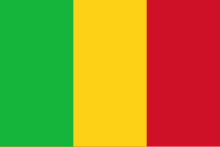

Guinea: 0.9936948023705305


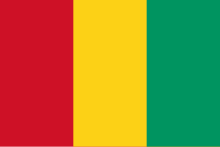

Romania: 0.9907543400259629


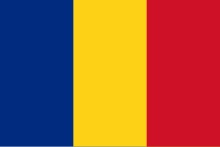

Chad: 0.9887326825368261


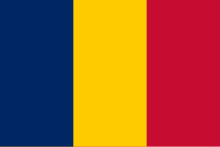

Ivory Coast: 0.9871369948367368


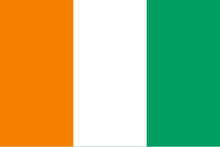

Italy: 0.9837211341242186


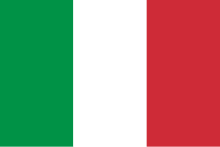

In [50]:
# Example usage
csv_file = 'national_flag_embeddings.csv'
df = pd.read_csv(csv_file)
input_country = 'Mali'
print(f"Input Country: {input_country}")
input_country_row = df[df['Country'] == input_country].iloc[0]

response = requests.get(input_country_row['Flag Image'])
img = Image.open(BytesIO(response.content))
display(img)

top_5_countries = get_top_5_similar_countries(input_country, csv_file)

for country, score in top_5_countries:
    country_row = df[df['Country'] == country].iloc[0]
    print(f"{country}: {score}")
    response = requests.get(country_row['Flag Image'])
    img = Image.open(BytesIO(response.content))
    display(img)